#**Computer Vision Based Drone and Bird Detection using Yolo model**

This notebook provides a detailed implementation of a drone and bird classification and detection system, using YOLOv11 model. The objective is to accurately detect and classify drones and birds in images, which can be used for real-time monitoring and tracking in diverse scenarios.

The project involves several key steps, including dataset preparation, model training and fine-tuning, and evaluation.

The dataset combines images from the Drone Dataset - UAE and the COCO-2017 Dataset to extract and annotate bird data. Model is fine-tuned using this merged dataset, and detection outputs were further integrated with DeepSort tracking algorithms for single object tracking in videos.

## **Colab setup**


In [4]:
def colabSetup():
  from google.colab import drive
  drive.mount('/content/drive')

  #Install packages
  !pip install ultralytics
  !pip install deep_sort_realtime
  !pip install tensorflow_docs
  !apt-get install -y ffmpeg


In [5]:
colabSetup()

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 13.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [6]:
# Import required libraries
import cv2
import os
import sys
import PIL
import matplotlib.pylab as plt
import numpy as np
import matplotlib.patches as patches
from ultralytics import YOLO

import shutil
import random
random.seed(42)
np.random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Data Prepararion Pipeline for Object Detection**

This section implement the process of preparing a comprehensive dataset for drone and bird detection tasks. It unzips the zip datasets and merges them into a unified format. It splits the dataset into training, validation, and testing subsets, ensuring a balanced distribution for effective training and evaluation for YOLO model.

### **Module to create dataset**

In [7]:
class YOLODatasetBuilder:
    def __init__(self, image_folder, output_folder, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
        """
        Initialize the dataset generator.
        :param image_folder: Path to the folder containing images and bounding box text files.
        :param output_folder: Path to the output folder where the YOLO dataset will be created.
        :param train_ratio: Ratio of data to be used for training.
        :param val_ratio: Ratio of data to be used for validation.
        :param test_ratio: Ratio of data to be used for testing.
        """
        self.image_folder = image_folder
        self.output_folder = output_folder
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio


    def create_yolo_dataset(self):
        """
        Create dataset structure with normalized annotations.
        """
        # Define output directories
        image_dirs = {
            'train': os.path.join(self.output_folder, 'images', 'train'),
            'val': os.path.join(self.output_folder, 'images', 'val'),
            'test': os.path.join(self.output_folder, 'images', 'test'),
        }
        label_dirs = {
            'train': os.path.join(self.output_folder, 'labels', 'train'),
            'val': os.path.join(self.output_folder, 'labels', 'val'),
            'test': os.path.join(self.output_folder, 'labels', 'test'),
        }

        # Create directories
        for directory in image_dirs.values():
            os.makedirs(directory, exist_ok=True)
        for directory in label_dirs.values():
            os.makedirs(directory, exist_ok=True)

        # Get image files and shuffle them
        images = [f for f in os.listdir(self.image_folder) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(images)

        # Split data into train, val, and test
        train_cutoff = int(len(images) * self.train_ratio)
        val_cutoff = train_cutoff + int(len(images) * self.val_ratio)

        dataset_splits = {
            'train': images[:train_cutoff],
            'val': images[train_cutoff:val_cutoff],
            'test': images[val_cutoff:],
        }

        # Process and move files
        for split, image_files in dataset_splits.items():
            for image_file in image_files:
                image_path = os.path.join(self.image_folder, image_file)
                label_path = os.path.splitext(image_path)[0] + '.txt'

                # Move image
                shutil.copy(image_path, os.path.join(image_dirs[split], image_file))
                # Move labels
                label_file = os.path.splitext(image_file)[0] + '.txt'
                shutil.copy(label_path, os.path.join(label_dirs[split], label_file))


    def check_Train_Validation_Test_Dataset_Available(self):
        """
        Check folders.
        """
        train_image_dir = os.path.join(self.output_folder, "images/train")
        val_image_dir = os.path.join(self.output_folder, "images/val")
        test_image_dir = os.path.join(self.output_folder, "images/test")
        train_label_dir = os.path.join(self.output_folder, "labels/train")
        val_label_dir = os.path.join(self.output_folder, "labels/val")
        test_label_dir = os.path.join(self.output_folder, "labels/test")

        # Check if all directories exist
        if os.path.isdir(train_image_dir) and os.path.isdir(val_image_dir) and os.path.isdir(test_image_dir) and \
            os.path.isdir(train_label_dir) and os.path.isdir(val_label_dir) and os.path.isdir(test_label_dir) :
            print("All dataset directories are present.")
            return True
        else:
            print("Some dataset directories are missing. Remove the DatasetYOLO folder first and Enter the UI option y to create new...")
            return False

    def count_files_in_folders(self, root_folder):
        """
        Count files in root folder.
        """
        folder_file_count = {}

        # Walk through each folder and subfolder
        for folder_path, subfolders, files in os.walk(root_folder):
            # Get the folder name
            folder_name = os.path.basename(folder_path)
            # Count the files in the current folder
            file_count = len(files)
            # Store the result
            folder_file_count[folder_name] = file_count

        return folder_file_count


### **unzip drone archive**

In [8]:
 %%capture

!unzip '/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/archive.zip' -d /content

### **unzip bird dataset**

In [9]:
 %%capture
!unzip '/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/birds.zip' -d /content

### **Merge bird and drone dataset**

In [10]:
def move_bird_images_labels_to_dataset(source_dir, dest_dir):
      """
      Move all files from bird folder to dataset folder.

      :param source_dir: Path to the source directory with subdirectories.
      :param dest_dir: Path to the destination directory.
      """

      # Walk through the source directory
      for root, _, files in os.walk(source_dir):
          for file in files:
              source_path = os.path.join(root, file)
              dest_path = os.path.join(dest_dir, file)

              # Check for duplicate filenames
              if os.path.exists(dest_path):
                  print(f"Duplicate file detected: {file}. Skipping.")
                  continue

              # Move the file
              shutil.move(source_path, dest_path)
              #print(f"Moved: {source_path} -> {dest_path}")



bird_data_directory = "/content/birds"
drone_data_directory = "/content/drone_dataset_yolo/dataset_txt"

move_bird_images_labels_to_dataset(bird_data_directory, drone_data_directory)

# Specify the root folder for merged drone and bird dataset
data_folder = "/content/DatasetYOLO/"

### **User Input to re-create new datafolders**

In [11]:
dataset_builder = YOLODatasetBuilder(
    image_folder = drone_data_directory,
    output_folder = data_folder,
    train_ratio = 0.7,
    val_ratio = 0.2,
    test_ratio = 0.1
)
if dataset_builder.check_Train_Validation_Test_Dataset_Available() == False:
    # Ask for user input
    user_input = input("Do you want to create new dataset folders? (y/n): ").strip().lower()

    # Check the input
    if user_input == 'y':
        dataset_builder.create_yolo_dataset()
    else:
        print("Do not create new dataset folders!")



Some dataset directories are missing. Remove the DatasetYOLO folder first and Enter the UI option y to create new...
Do you want to create new dataset folders? (y/n): y


In [12]:
# Get file counts
result = dataset_builder.count_files_in_folders(data_folder + "images")

# Print the counts
for folder, count in result.items():
    print(f"Folder: {folder}, Files: {count}")

# Get file counts
result = dataset_builder.count_files_in_folders(data_folder + "labels")

# Print the counts
for folder, count in result.items():
    print(f"Folder: {folder}, Files: {count}")

Folder: images, Files: 0
Folder: val, Files: 532
Folder: train, Files: 1861
Folder: test, Files: 267
Folder: labels, Files: 0
Folder: val, Files: 532
Folder: train, Files: 1861
Folder: test, Files: 267


## **YOLO-Training**

### **Load pre-trained YOLO11l**

In [13]:
# Load a pretrained YOLO11l model
def loadPreTrainedYoloModel(mCheckPoint):
  model = YOLO(mCheckPoint)
  return model

# Define pre-trained yolo model check point
mCheckPoint = 'yolo11l.pt'
model_yolo = loadPreTrainedYoloModel(mCheckPoint)

100%|██████████| 49.0M/49.0M [00:01<00:00, 49.4MB/s]


### **Show pre-trained yolo results**

In [14]:
def showDetectionsYoloModel(model, test_img, model_train_title):
  results = model(test_img, save=True)[0]
  class_ids = results.boxes.cls.cpu().numpy()
  detections = results.boxes.xyxy.cpu().numpy()
  confidences  = results.boxes.conf.cpu().numpy()
  print(f"Acquired {len(detections)} detections. ")

  for i, class_id in enumerate(class_ids):
    print
    class_name = model_yolo.names[class_id]
    print(f"class: {model_yolo.names[class_id]}, bounding box: {detections[i]}, confidence: {confidences[i]}")

  output_image_path = os.path.join(results.save_dir, os.path.basename(test_img))


  img = cv2.imread(output_image_path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(f'Detection results of {model_train_title} {model.model_name}')
  plt.show()

  return results


image 1/1 /content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/0001.jpg: 288x640 6 airplanes, 76.8ms
Speed: 17.1ms preprocess, 76.8ms inference, 767.7ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict
Acquired 6 detections. 
class: airplane, bounding box: [     149.32      271.89       459.2      381.08], confidence: 0.8787636756896973
class: airplane, bounding box: [     711.79       167.6      862.83      211.32], confidence: 0.8605136275291443
class: airplane, bounding box: [     30.123      197.65      174.07      244.15], confidence: 0.8490846157073975
class: airplane, bounding box: [     117.93       29.07      819.14      243.86], confidence: 0.8211482763290405
class: airplane, bounding box: [     203.69           0      284.54      27.859], confidence: 0.7876976132392883
class: airplane, bounding box: [     596.51      305.95      701.41      344.04], confidence: 0.7507901191711426


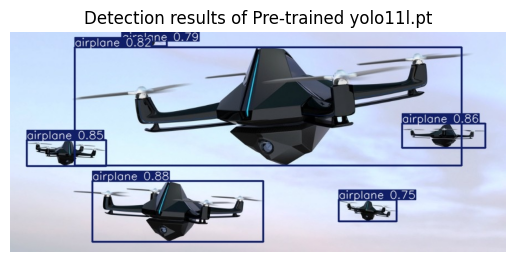

In [15]:
test_img = '/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/0001.jpg'
results = showDetectionsYoloModel(model=model_yolo, test_img=test_img, model_train_title="Pre-trained")

### **Custom-train YOLO11l**

I used a pretrained YOLOv11 large variant (yolo11l.pt) and configured it to detect two classes: drones and birds, as specified in the dataset configuration file (yolo_drone.yaml). The training is conducted for 50 epochs on 640x640 images with a batch size of 32, utilizing an NVIDIA A100 GPU with mixed precision training (AMP) enabled to enhance performance. AdamW optimizer is selected for the training.

In [16]:
# yolo_drone.yaml - setup for dataset folders for train/val/test, class ids, number of classes.
drone_yaml_path="/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/yolo_drone.yaml"

NUM_EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 640

# Train with scale augmentation
SCALE_AUGMENTATION = 0.5

results_train = model_yolo.train(data=drone_yaml_path, epochs=NUM_EPOCHS, batch=BATCH_SIZE, imgsz=IMG_SIZE, scale=SCALE_AUGMENTATION, visualize=True, seed=42)

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/yolo_drone.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

100%|██████████| 755k/755k [00:00<00:00, 90.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 350MB/s]


AMP: checks passed ✅


train: Scanning /content/DatasetYOLO/labels/train... 1861 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1861/1861 [00:02<00:00, 737.82it/s]

train: WARNING ⚠️ /content/DatasetYOLO/images/train/pic_722.jpg: corrupt JPEG restored and saved
train: New cache created: /content/DatasetYOLO/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/DatasetYOLO/labels/val... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<00:00, 643.30it/s]

val: New cache created: /content/DatasetYOLO/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      21.3G      2.189      2.685      2.247         32        640: 100%|██████████| 59/59 [00:22<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


                   all        532       1168      0.551      0.486      0.482      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      21.4G      1.622       1.69      1.678         22        640: 100%|██████████| 59/59 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]


                   all        532       1168      0.629      0.542      0.565      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      21.4G      1.584      1.536      1.626         16        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]


                   all        532       1168      0.505      0.452      0.458      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      21.3G      1.574      1.483      1.599         26        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        532       1168      0.655      0.549      0.575      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      21.5G      1.532      1.407      1.586         10        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        532       1168      0.619      0.523      0.558      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      21.4G       1.47      1.354      1.517         27        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


                   all        532       1168       0.65      0.517      0.561      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      21.5G       1.44      1.294       1.51         17        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        532       1168      0.674       0.59      0.623      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      21.4G      1.397      1.258       1.47         14        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        532       1168      0.736      0.593      0.645      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      21.5G      1.354      1.169      1.442         22        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        532       1168      0.711      0.564      0.612      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      21.4G      1.334      1.141      1.429         25        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        532       1168      0.707      0.552        0.6      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      21.5G      1.332      1.117      1.431         16        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        532       1168      0.701      0.629      0.654      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      21.4G      1.301      1.097      1.393         11        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        532       1168      0.799      0.596       0.66      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      21.5G       1.29      1.068      1.396         20        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        532       1168        0.7      0.621      0.654      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      21.4G      1.275      1.059      1.378         18        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        532       1168      0.766      0.618       0.67       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      21.5G      1.251      1.006      1.367         17        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.774      0.644      0.688      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      21.4G      1.233      1.004      1.341         16        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        532       1168      0.797      0.642      0.696      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      21.5G      1.208     0.9676      1.335         17        640: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        532       1168      0.734      0.676      0.695      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      21.4G      1.207     0.9437      1.322         43        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        532       1168      0.762      0.649      0.686      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      21.5G       1.18     0.9314      1.323         26        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        532       1168      0.707      0.683      0.684      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      21.4G      1.168     0.9154      1.304         22        640: 100%|██████████| 59/59 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        532       1168      0.752       0.67      0.692      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      21.5G      1.132     0.8501      1.272         21        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.763      0.674      0.708      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      21.5G      1.136     0.8718      1.292         23        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.763      0.677      0.717      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      21.5G      1.106     0.8303      1.278         14        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        532       1168      0.825      0.636      0.703      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      21.4G      1.123     0.8318      1.272         35        640: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        532       1168      0.805      0.673      0.723      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      21.5G      1.099     0.8084      1.249         51        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        532       1168      0.795      0.663      0.704      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      21.3G      1.087     0.8045      1.252         23        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        532       1168      0.794      0.667      0.707      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      21.6G      1.077      0.798      1.255         25        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        532       1168      0.806      0.679      0.713      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      21.4G      1.061     0.7764      1.254         14        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        532       1168      0.752      0.698      0.715      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      21.5G       1.05     0.7655      1.253         22        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        532       1168       0.78      0.681      0.724      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      21.5G       1.03     0.7321      1.226         24        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        532       1168      0.775      0.719       0.73      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      21.5G      1.018     0.7023      1.215         20        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        532       1168      0.821      0.695       0.74      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      21.4G       1.02     0.7105      1.207         35        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        532       1168      0.807      0.694      0.736       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      21.5G     0.9939     0.6847      1.203         21        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        532       1168       0.79      0.703      0.733      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      21.3G      0.989     0.7081      1.186         11        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.797      0.703      0.735      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      21.5G     0.9834      0.668       1.18         26        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        532       1168      0.814      0.697       0.74      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      21.3G     0.9621     0.6481      1.176         25        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        532       1168      0.814      0.698       0.74      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      21.5G     0.9403     0.6408      1.165         17        640: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        532       1168      0.796       0.69      0.728      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      21.3G      0.927     0.6275       1.15         37        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        532       1168      0.796        0.7      0.738      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      21.5G     0.9223      0.612      1.161         10        640: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        532       1168        0.8      0.705      0.743      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      21.4G      0.906     0.6057      1.142         11        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        532       1168      0.816      0.707      0.743      0.508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      21.6G     0.8243     0.5146      1.081          7        640: 100%|██████████| 59/59 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.802      0.692      0.742      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      21.4G     0.8247     0.4953      1.071         14        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        532       1168      0.792      0.713      0.742      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      21.5G     0.8183      0.478      1.059         12        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        532       1168      0.795      0.703       0.74      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      21.3G      0.806     0.4669      1.045          7        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        532       1168      0.807      0.702       0.74      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      21.6G     0.7826     0.4503      1.039         29        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        532       1168      0.813      0.705      0.743      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      21.5G     0.7621      0.443      1.032          5        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        532       1168      0.796      0.709      0.744      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      21.5G     0.7447     0.4234      1.024         12        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        532       1168      0.815      0.697      0.739      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      21.4G     0.7397     0.4224      1.032         15        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        532       1168      0.804      0.711      0.748      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      21.5G     0.7367      0.416      1.017         17        640: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        532       1168      0.818      0.709       0.75      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      21.4G     0.7281     0.4121      1.023          9        640: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        532       1168      0.817       0.71      0.752      0.529



50 epochs completed in 0.335 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11l summary (fused): 464 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


                   all        532       1168      0.817      0.711      0.752      0.529
                 drone        284        300      0.965      0.963      0.982      0.736
                  bird        248        868      0.668      0.458      0.523      0.321
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


In [17]:
results_train.save_dir

PosixPath('runs/detect/train')

### Load and test YOLO model with the best weight acquired during training


image 1/1 /content/DatasetYOLO/images/train/000000000143.jpg: 544x640 9 birds, 71.9ms
Speed: 2.6ms preprocess, 71.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/detect/predict2
Acquired 9 detections. 
class: bird, bounding box: [     125.37      103.57      223.07      272.39], confidence: 0.9282195568084717
class: bird, bounding box: [     112.79      322.95      207.43      494.15], confidence: 0.9257650375366211
class: bird, bounding box: [     426.62      192.35      560.37      366.95], confidence: 0.9161816835403442
class: bird, bounding box: [     30.009      18.335      131.93         155], confidence: 0.913362979888916
class: bird, bounding box: [     119.06      236.08      234.36      373.79], confidence: 0.9056270718574524
class: bird, bounding box: [     267.45      129.67      365.85      290.51], confidence: 0.9017887115478516
class: bird, bounding box: [     466.36      322.68      561.73      474.15], confidence: 0.901300370

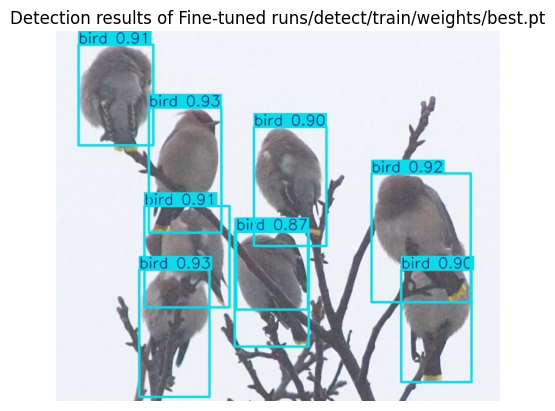


image 1/1 /content/DatasetYOLO/images/train/0001.jpg: 288x640 6 drones, 75.7ms
Speed: 2.1ms preprocess, 75.7ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict2
Acquired 6 detections. 
class: drone, bounding box: [     595.19      296.68      700.64      351.77], confidence: 0.8867902159690857
class: drone, bounding box: [     128.99      21.286      825.36      250.92], confidence: 0.8660977482795715
class: drone, bounding box: [     115.49      265.87       455.8      382.84], confidence: 0.8501767516136169
class: drone, bounding box: [     27.397      185.84      174.04      252.29], confidence: 0.8438206315040588
class: drone, bounding box: [     711.56      158.51      864.19      218.56], confidence: 0.8282256126403809
class: drone, bounding box: [     194.59           0      288.11      33.782], confidence: 0.8042269945144653


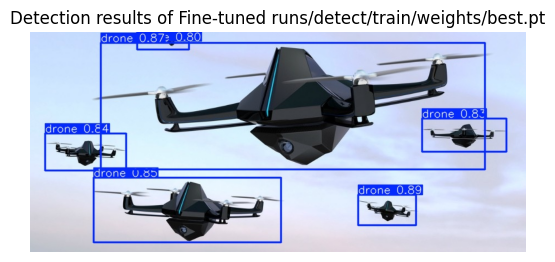

In [18]:
# To visualize the image with predictions

# Load best trained weight of yolo model
yolo_best_wt_path = os.path.join(results_train.save_dir, 'weights/best.pt')

model_yolo_custom = YOLO(yolo_best_wt_path)

# Perform inference using trained model
test_image_path = "/content/DatasetYOLO/images/train/000000000143.jpg"
results_pred = showDetectionsYoloModel(model=model_yolo_custom, test_img=test_image_path, model_train_title="Fine-tuned")
test_image_path = "/content/DatasetYOLO/images/train/0001.jpg"
results_pred = showDetectionsYoloModel(model=model_yolo_custom, test_img=test_image_path, model_train_title="Fine-tuned")


### **Learning curve**

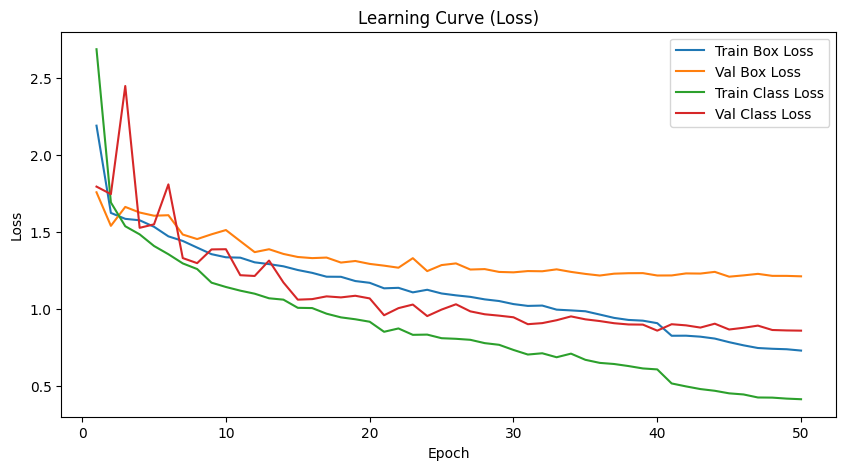

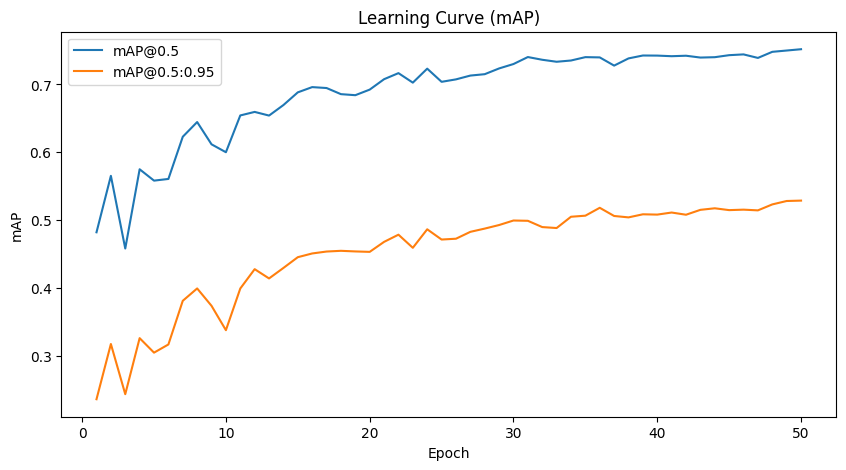

In [19]:
# Show the learning curve and confusion matrix of training
import pandas as pd
import matplotlib.pyplot as plt

# Load the results file
results_learning_c = os.path.join(results_train.save_dir, 'results.csv')
results_cf = pd.read_csv(results_learning_c)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(results_cf['epoch'], results_cf['train/box_loss'], label='Train Box Loss')
plt.plot(results_cf['epoch'], results_cf['val/box_loss'], label='Val Box Loss')
plt.plot(results_cf['epoch'], results_cf['train/cls_loss'], label='Train Class Loss')
plt.plot(results_cf['epoch'], results_cf['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()
plt.show()

# Plot mAP (mean Average Precision)
plt.figure(figsize=(10, 5))
plt.plot(results_cf['epoch'], results_cf['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results_cf['epoch'], results_cf['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Learning Curve (mAP)')
plt.legend()
plt.show()


### **Validation results after training**
Evaluated on 532 validation images with 1232 instances (ground truth objects):

Precision: 0.785 (high accuracy in identifying objects).
Recall: 0.684 (reasonable object detection coverage).
mAP50: 0.726 (good bounding box alignment).
mAP50-95: 0.477 (lower for stricter IoU thresholds).

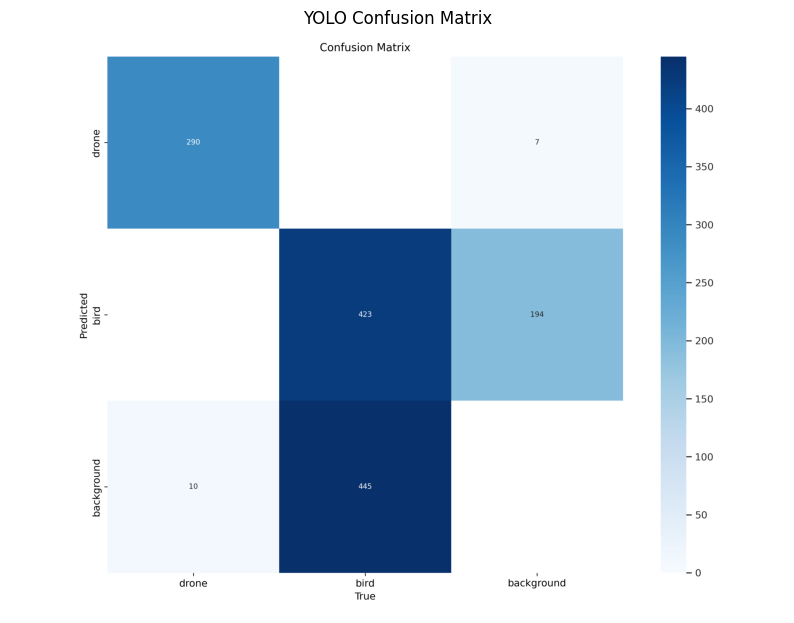

In [20]:
# Show confusion matrix
confusion_matrix_path = os.path.join(results_train.save_dir, 'confusion_matrix.png')

# Display the image
plt.figure(figsize=(10, 10))
img = plt.imread(confusion_matrix_path)
plt.imshow(img)
plt.axis('off')
plt.title("YOLO Confusion Matrix")
plt.show()

In [21]:
# Test

### **Validate on Unseen test dataset**

In [22]:
# Test the trained model on unseen data
results_test = model_yolo_custom.val(
    data=drone_yaml_path,
    split='test', save=True)


Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/DatasetYOLO/labels/test... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 686.01it/s]

val: New cache created: /content/DatasetYOLO/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.85it/s]


                   all        267        579      0.796      0.718       0.75      0.511
                 drone        133        150      0.932      0.907      0.934      0.682
                  bird        134        429       0.66      0.529      0.566      0.341
Speed: 0.1ms preprocess, 5.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


###**Save model**

In [23]:
shutil.copy(yolo_best_wt_path, "/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/YOLO11_Model_best_checkpoint/yolo_best.pt")

'/content/drive/MyDrive/USD/AAI-521_ComputerVision/FinalProject/YOLO11_Model_best_checkpoint/yolo_best.pt'

### **Results of the Unseen test dataset**

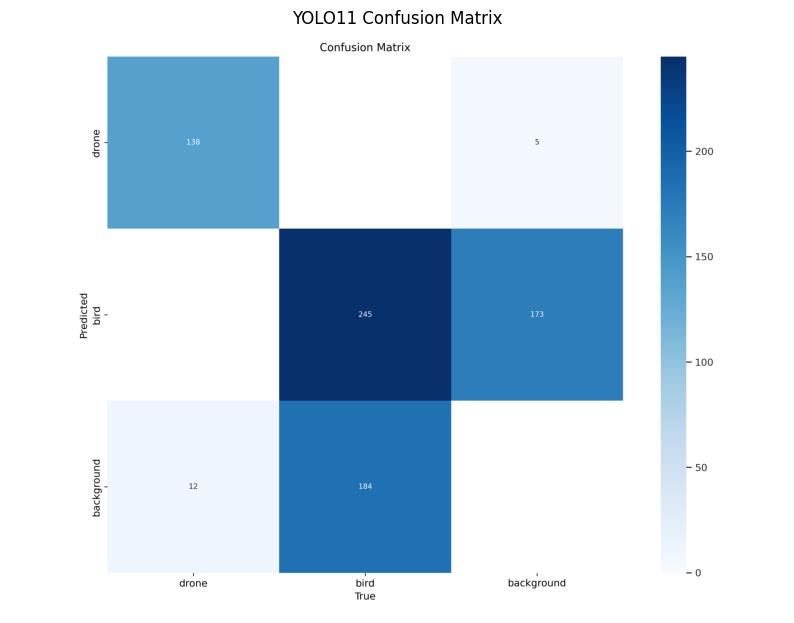

In [24]:
# Show confusion matrix
confusion_matrix_path = os.path.join(results_test.save_dir, 'confusion_matrix.png')

# Display the image
plt.figure(figsize=(10, 10))
img = plt.imread(confusion_matrix_path)
plt.imshow(img)
plt.axis('off')
plt.title("YOLO11 Confusion Matrix")
plt.show()

After training, the validation results include class-specific metrics:

Drone:
High precision (0.939) and recall (0.936), indicating excellent performance in detecting drones.
mAP50: 0.975 (very accurate bounding box predictions for drones).
mAP50-95: 0.668 (good performance at stricter thresholds).
Bird:
Lower precision (0.632) and recall (0.431), indicating more difficulty in detecting birds.
mAP50: 0.478 (moderate accuracy for bounding boxes).
mAP50-95: 0.285 (low performance at stricter thresholds).
This discrepancy may indicate that the model has learned to detect drones better, possibly due to imbalanced data (fewer birds in the dataset or more challenging annotations).

## **Summary**

The model shows strong performance in detecting drones (high mAP50 and recall) but struggles more with birds.
Training over 10 epochs improved detection metrics significantly, but additional fine-tuning (e.g., longer training or balanced data) could enhance bird detection.
The combination of mixed precision training, effective data augmentation, and a well-optimized YOLOv11 architecture enables efficient training on the custom dataset.